In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import cv2

In [30]:
path = "./germany_dataset/train.csv"
df = pd.read_csv(path)
df = df.dropna()
df['Rotate'] = 0

In [31]:
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Rotate,length,height
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,0,17,15
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,0,18,16
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,0,18,16
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,0,18,16
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,0,18,16


In [32]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.0,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390,0.0,39.197786,38.765998
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238,0.0,21.821369,20.828697
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000,0.0,15.000000,15.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000,0.0,24.000000,24.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000,0.0,33.000000,32.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000,0.0,47.000000,47.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000,0.0,203.000000,185.000000


In [33]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 50
resize_y  = 50
num_of_channels = 3
directory = "./germany_dataset/"
Epochs=25
train_length = len(df)

In [34]:
# Necessary Functions
def remove_outlier(df,parameter):
    Percentile25 = df[parameter].quantile(0.25)
    Percentile75 = df[parameter].quantile(0.75)
    iqr = Percentile75 - Percentile25
    lowerlimit = Percentile25 - 1.5*iqr
    upperlimit = Percentile75 + 1.5*iqr
    temp1 = df[parameter]>lowerlimit
    temp2 = df[parameter]<upperlimit
    return df[temp1 & temp2] 

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
def upSampleDataFrame(df,upSampleCount=300):
    starting_time = time.time()
    classes = {}

    for val in range(num_of_classes):
        classes[val]=[]

    max_repeating = 0

    for index,row in df.iterrows():
        classes[row.values[6]].append(row.values)

    # for key in classes:
    #     max_repeating = max(max_repeating,len(classes[key]))
    
    row = []
    random.seed(42)
    for i in range(num_of_classes):
        length = len(classes[i])
        want = upSampleCount - length
        for j in range(len(classes[i])):
            row.append(classes[i][j])
        if(want<=0):
            continue
        for j in range(want):
            select_image = random.randint(0,length-1)
            angle = random.randint(0,359)
            f = classes[i][select_image].copy()
            f[8] = angle
            row.append(f)
    np.random.seed(42)
    np.random.shuffle(row)

    df = pd.DataFrame(row,columns = df.columns)

    ending_time = time.time()
    total_time = ending_time - starting_time
    total_time/=60
    print("Total number of images after Upsampling: ", len(df))
    print("\n\nTime taken to upsample images : ",total_time," min")
    return df

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).rotate(row[8]).resize((resize_x,resize_y)))
        y_test.append(row[6])

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).rotate(row[8]).resize((resize_x,resize_y)))
        y_test.append(row[6])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  39209


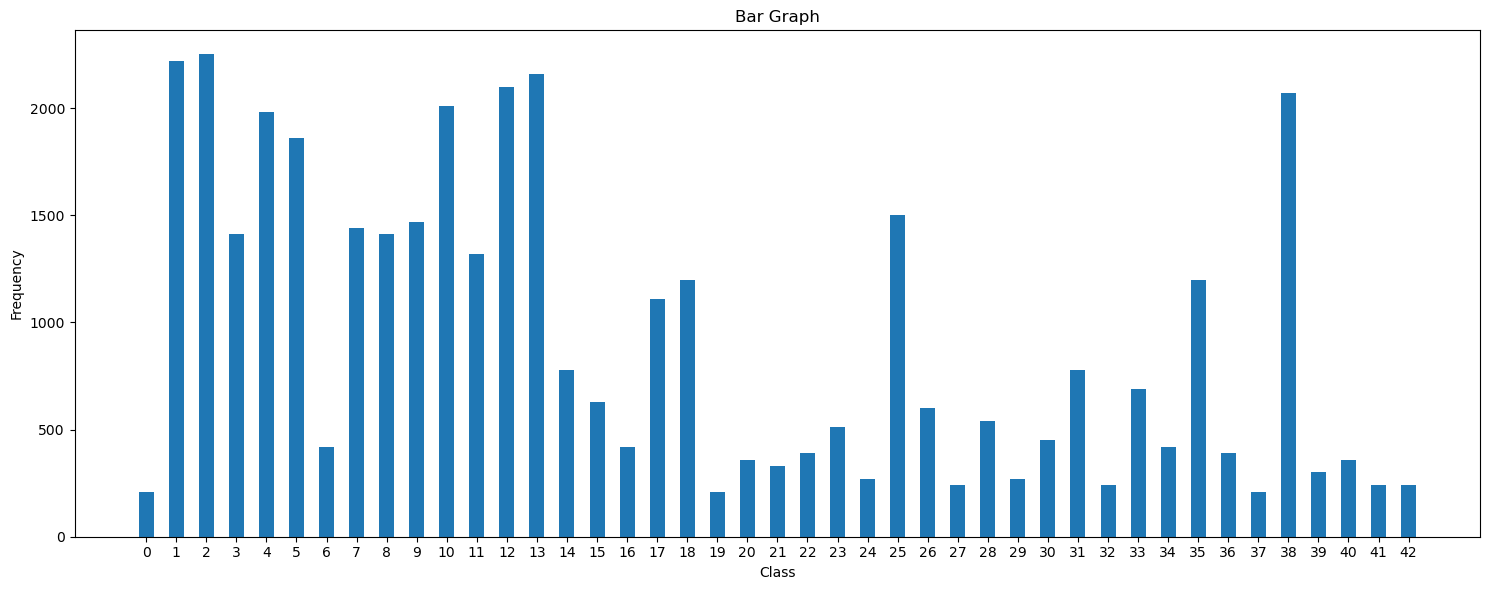

In [35]:
#Statistics of Data
viewStatistics(df)

In [36]:
df = remove_outlier(df,"length")
df = remove_outlier(df,"height")

Total Training Examples :  36312


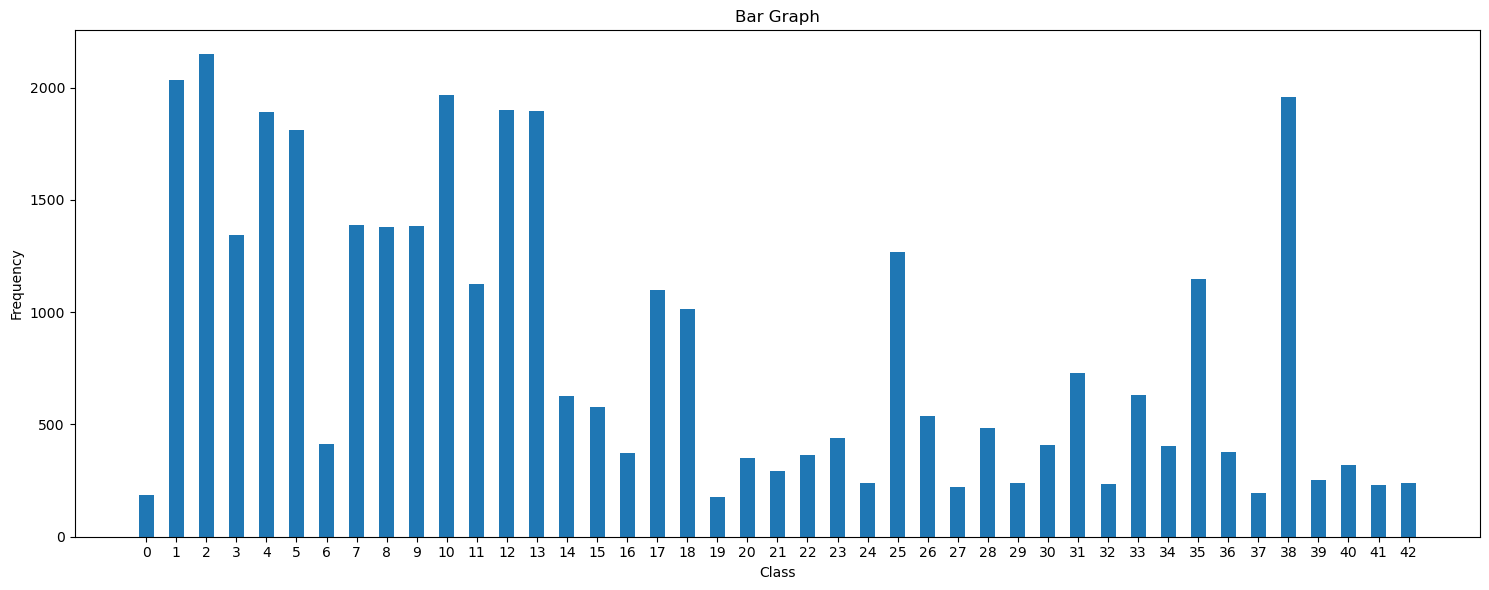

In [37]:
#Statistics of Data
viewStatistics(df)

In [38]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  36312


Total number of images after Upsampling:  40368


Time taken to upsample images :  0.02496666113535563  min
Total Training Examples :  40368


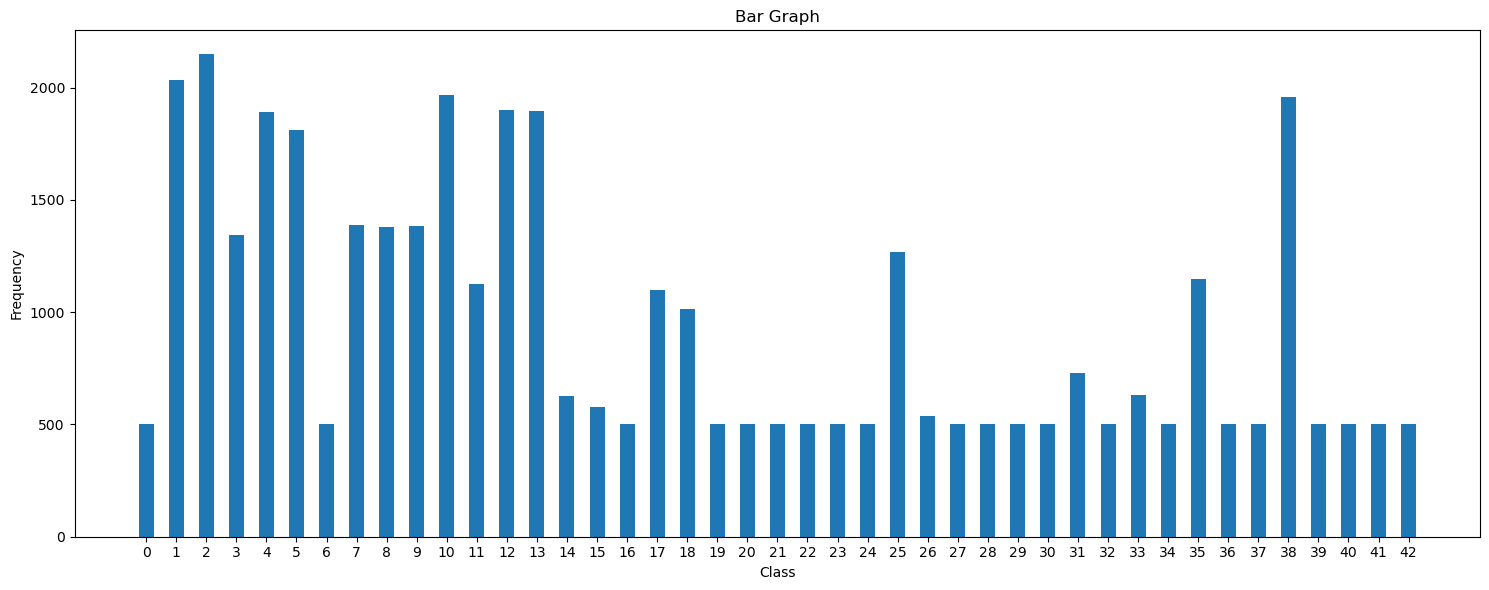

In [39]:
df = upSampleDataFrame(df,500)
viewStatistics(df)

In [40]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[7])
        ax.imshow(img)
        img = img.crop((val[2],val[3],val[4],val[5]))
        img = img.rotate(val[8])
        ax = axes[row,col+1]
        ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

In [41]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y
    
    def resize_and_center(self,image, target_height, target_width):
        original_height, original_width= image.size
        height_ratio = target_height / original_height
        width_ratio = target_width / original_width
        resize_ratio = min(height_ratio, width_ratio)
        new_height = int(original_height * resize_ratio)
        new_width = int(original_width * resize_ratio)
        image  = np.array(image)
        resized_image = cv2.resize(image, (new_width, new_height))
        pad_height = max(0, (target_height - new_height) // 2)
        pad_width = max(0, (target_width - new_width) // 2)
        centered_image = cv2.copyMakeBorder(resized_image, pad_height, target_height - new_height - pad_height,pad_width, target_width - new_width - pad_width,cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return centered_image

    def Do_Crop(self,path,x1,y1,x2,y2,r):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        img = img.rotate(r)
        img = self.resize_and_center(img,self.resize_x,self.resize_y)
        img = np.array(img,dtype=float)
        return img
    
    def Row_Data(self,row):
        self.X.append(self.Do_Crop(row.iloc[7],row.iloc[2],row.iloc[3],row.iloc[4],row.iloc[5],row.iloc[8]))
        self.Y.append(int(row.iloc[6]))
    
    def Get_Data(self,length):
        self.X = []
        self.Y = []
        want = [0]*num_of_classes
        for i in range(len(df)):
            row = df.iloc[i]
            if(want[int(row.iloc[6])]<length):
                want[int(row.iloc[6])] = want[int(row.iloc[6])]+1
                self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)
        
    def Get_Data(self):
        self.X = []
        self.Y = []
        for i in range(len(df)):
            row = df.iloc[i]
            self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)

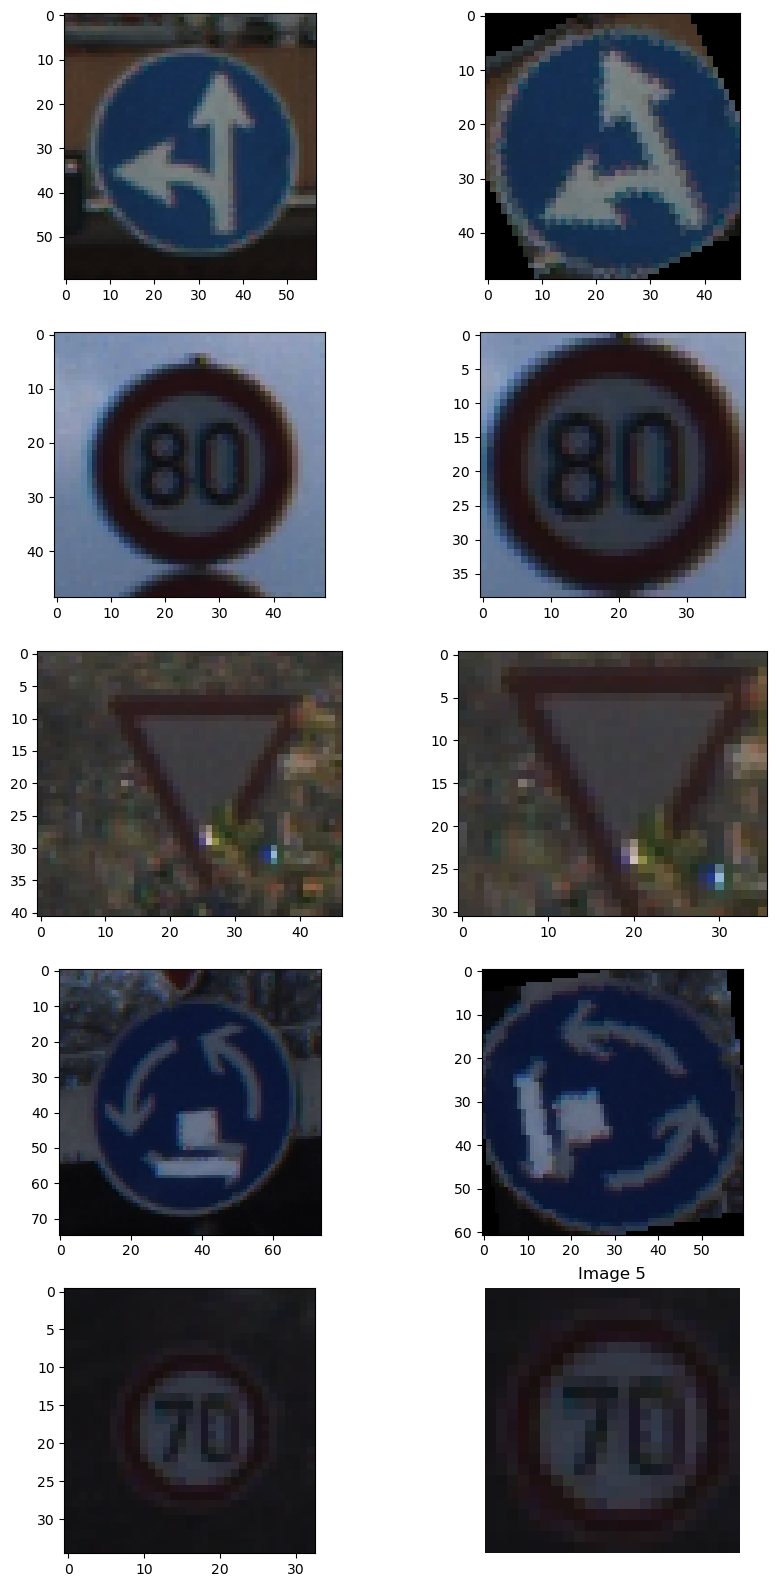

In [42]:
showExamples(df)

In [43]:
# Reading images from local storage
starting_time = time.time()

data = Data(df,resize_x,resize_y)
data.Get_Data()

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to read images : ",total_time," min")

Time taken to read images :  0.7456746260325114  min


In [44]:
X_train = data.X
Y_train = data.Y

In [45]:
#Data_Augmentation
X_train = X_train/255.0

In [46]:
# conversion of Y_train into 2d array in order to feed CNN 
Temp = []
for i in range(len(Y_train)):
    row = [0]*num_of_classes
    row[Y_train[i]]=1
    Temp.append(np.array(row))
Y_train = np.array(Temp)

In [47]:
# Implementation of cnn
model = Sequential()
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(resize_x, resize_y, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_of_classes, activation='softmax') 
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)       

In [48]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
starting_time = time.time()

history = model.fit(X_train,Y_train,epochs=Epochs,batch_size=32,validation_split=0.2)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken fit : ",total_time," min")

Epoch 1/25
1010/1010 [==============================] - 114s 108ms/step - loss: 1.8886 - accuracy: 0.4407 - val_loss: 0.5170 - val_accuracy: 0.8437
Epoch 2/25
1010/1010 [==============================] - 104s 103ms/step - loss: 0.5231 - accuracy: 0.8331 - val_loss: 0.2379 - val_accuracy: 0.9310
Epoch 3/25
1010/1010 [==============================] - 119s 117ms/step - loss: 0.2814 - accuracy: 0.9100 - val_loss: 0.1612 - val_accuracy: 0.9498
Epoch 4/25
1010/1010 [==============================] - 110s 109ms/step - loss: 0.1959 - accuracy: 0.9389 - val_loss: 0.1240 - val_accuracy: 0.9630
Epoch 5/25
1010/1010 [==============================] - 117s 116ms/step - loss: 0.1569 - accuracy: 0.9501 - val_loss: 0.1276 - val_accuracy: 0.9636
Epoch 6/25
1010/1010 [==============================] - 117s 116ms/step - loss: 0.1291 - accuracy: 0.9582 - val_loss: 0.0939 - val_accuracy: 0.9742
Epoch 7/25
1010/1010 [==============================] - 121s 120ms/step - loss: 0.1100 - accuracy: 0.9653 - val_

In [ ]:
#Saving the model
model.save("CNN_SimpleLayered")

In [22]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

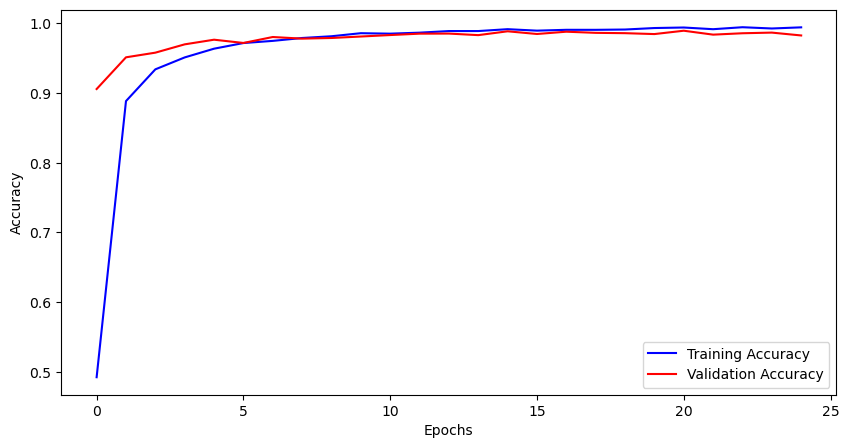

In [23]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

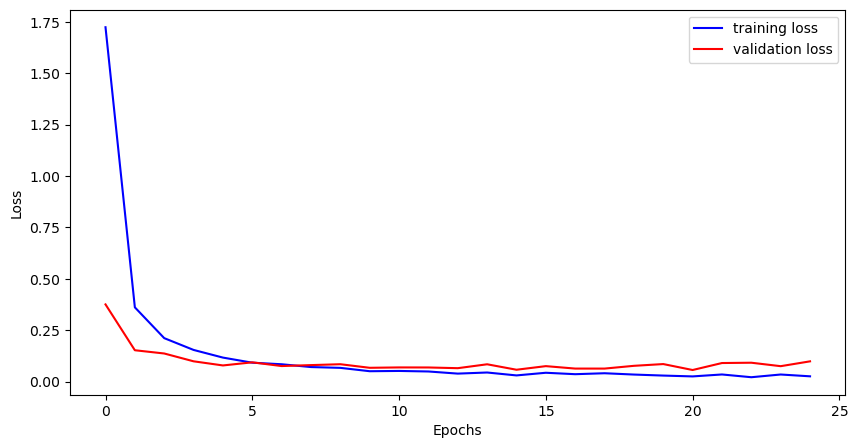

In [24]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [ ]:
#Loading weights into CNN model 
model = tf.keras.models.load_model("CNN_SimpleLayered")

In [25]:
df_test = pd.read_csv("./germany_dataset/test.csv")
print("Number of Test Images are ", len(df_test))
df_test.dropna()
df_test['Rotate']=0
df_test.head()

Number of Test Images are  12630


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Rotate
0,53,54,6,5,48,49,16,Test/00000.png,0
1,42,45,5,5,36,40,1,Test/00001.png,0
2,48,52,6,6,43,47,38,Test/00002.png,0
3,27,29,5,5,22,24,33,Test/00003.png,0
4,60,57,5,5,55,52,11,Test/00004.png,0


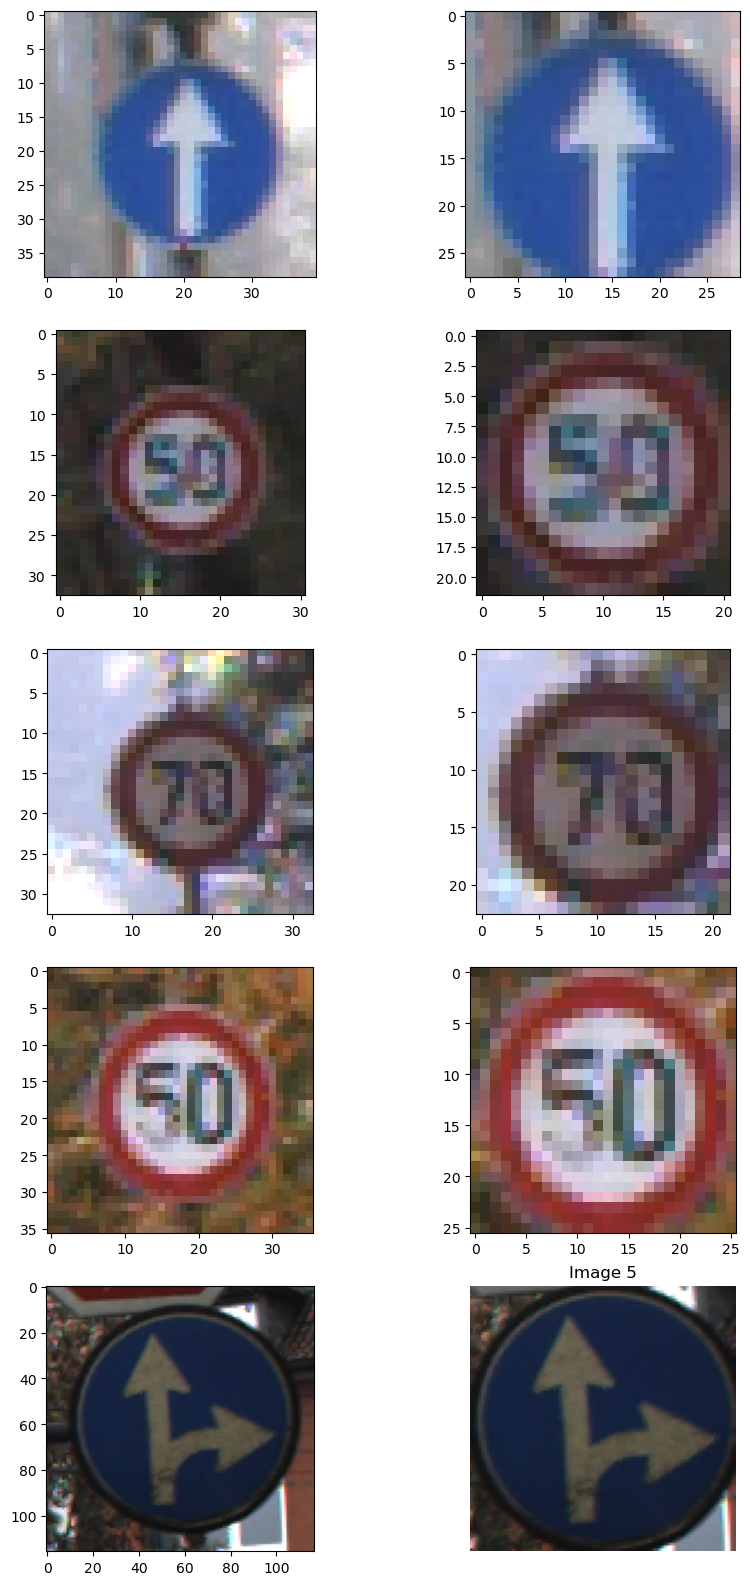

In [26]:
showExamples(df_test)

In [27]:
df_test = upSampleDataFrame(df_test,750)

Total number of images after Upsampling:  32250


Time taken to upsample images :  0.010966702302296957  min


In [28]:
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
count,32250.000000,32250.000000,32250.000000,32250.000000,32250.000000,32250.000000,32250.000000,32250.000000
mean,52.705798,52.170202,6.127938,6.094946,46.927535,46.452837,21.000000,108.913085
std,28.786028,26.495038,1.864891,1.663619,27.159467,25.034310,12.409866,119.582510
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,30.000000,10.000000,0.000000
50%,44.000000,44.000000,6.000000,6.000000,38.000000,39.000000,21.000000,62.000000
75%,60.000000,59.000000,6.000000,6.000000,55.000000,54.000000,32.000000,211.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000,359.000000


In [29]:
# Test Images Prediction
y_test,y_pred = PredictTest(model,df_test)

1008/1008 [==============================] - 25s 25ms/step


In [30]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  70.68837209302326

Confusion Matrix:
 [[702  14  13 ...   1   0   0]
 [ 27 713   2 ...   0   1   0]
 [  0   3 740 ...   0   0   0]
 ...
 [  0   1   0 ... 714   4   0]
 [  4   1   3 ...   0 472   0]
 [  0   0   0 ...   3 275 429]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,0,0.43,0.94,0.59,750
1,1,0.88,0.95,0.91,750
2,2,0.89,0.99,0.94,750
3,3,0.98,0.60,0.75,750
4,4,0.98,0.86,0.92,750
5,5,0.85,0.84,0.85,750
6,6,0.93,0.67,0.78,750
7,7,0.95,0.64,0.76,750
8,8,0.93,0.63,0.75,750
9,9,0.88,0.72,0.79,750


Original Value :  32
1/1 [==============================] - 0s 28ms/step
Predicted Value :  32


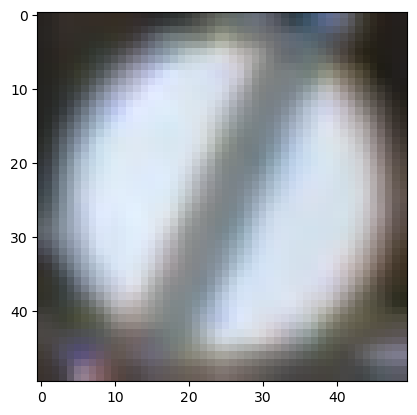

In [31]:
# Testing one Random Image from test data 
test_length = len(df_test)
select_row=random.randint(0,test_length-1)
row = df_test.iloc[select_row]
print("Original Value : ",df_test.iloc[select_row,6])
img = Image.open(directory+row.iloc[7])
img = img.crop((row.iloc[2],row.iloc[3],row.iloc[4],row.iloc[5]))
img = img.resize((resize_x,resize_y))
plt.imshow(img)
img  = np.array(img)
img  = tf.convert_to_tensor(img,dtype=float)
img = img/255.0
img = tf.expand_dims(img, axis=0)
probability = model.predict(img)
value = get_max_index(probability[0])
print("Predicted Value : ",value)

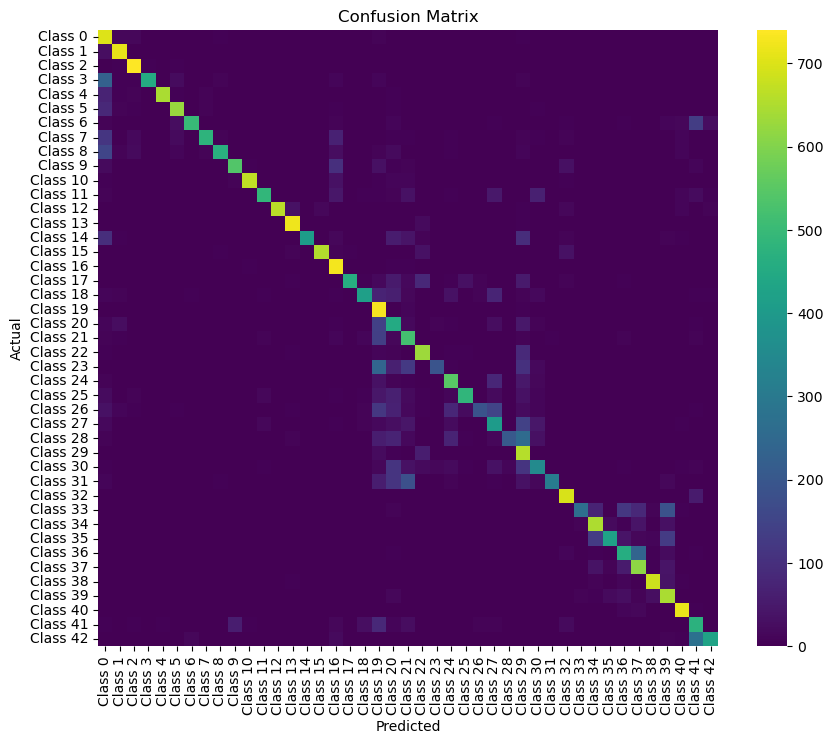

In [32]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()